Notebook for Optim application. Notebook for supplementary material of a submitted publication. 

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json


%matplotlib widget
import time
import numpy as np
from aeromaps import create_process
from aeromaps.core.models import (
    models_optim_simple,
)

import gemseo as gm
gm.configure_logger()

<RootLogger root (INFO)>

# 1- Scenario initialisation and settings

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [2]:
from aeromaps.utils.functions import create_partitioning

In [3]:
create_partitioning(file="data_optim/aeroscope_europe_data.csv", path="data_optim")

## 2. Run AeroMAPS on this studied scope

In [4]:
%matplotlib widget
from aeromaps import create_process
from aeromaps.core.models import default_models_top_down

In [5]:
models = {
    "models_optim_simple": models_optim_simple,
}

Create process as usual, the partitionning is recuperated as specified in the config file.

In [6]:
process = create_process(
    configuration_file="data_optim/config.json",
    models=models,
    use_fleet_model=False
)

## 1-a) Air traffic evolution

As of April 2024, AeroMAPS is considering an exgenous growth rate.
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).


In [7]:
## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [1.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [1.0]

## 1-b) Aircraft fleet

Top-down fleet, without hydrogen aircraft, callibrated on the fleet of the MACC applciation, with drop-in instead of h2  
http://localhost:8888/lab/tree/aeromaps/notebooks/data_cost/top_down_cost_callibration_phd.ipynb

Mean annual efficiency improvement: 1.4% --> applied to all catgeories

In [8]:
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [1.4]

## Hydrogen aircraft
# NONE

### 1-c) Operational improvements

Operational improvements are considered via two opportunities. 
- Load factor improvement: improvement to 89% at the end of the scenario.
- Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y. 

Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled, but not considered in this article due to lack of specific informations to the best of our knowldege.


In [9]:
process.parameters.load_factor_end_year = 89.0  # 2019 value: 82.399312

In [10]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## 1-d) Energy

Top-down callibrated on the values of teh MACC apllication.
Faster optim but caution as MFSP full computation is more detailled: larges use of e-fuel in the begining influence late mFSp (no-decomissioning)

In [11]:
# # Energy settings: production choices

# # Aircraft energy - Introduction of alternative drop-in fuels

# ## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.biofuel_share_reference_years_values = [0, 2, 4.8, 15, 24, 27, 35]
process.parameters.electrofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.electrofuel_share_reference_years_values = [0, 0, 1.2, 5, 10, 15, 35]


## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = []
process.parameters.biofuel_hefa_fog_share_reference_years_values = [0.6]
process.parameters.biofuel_hefa_others_share_reference_years = []
process.parameters.biofuel_hefa_others_share_reference_years_values = [12.5]
process.parameters.biofuel_ft_others_share_reference_years = []
process.parameters.biofuel_ft_others_share_reference_years_values = [68.9]
process.parameters.biofuel_ft_msw_share_reference_years = []
process.parameters.biofuel_ft_msw_share_reference_years_values = [6.6]


In [12]:
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years_values = [0.815488]
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years_values = [1.052703]
process.parameters.biofuel_ft_others_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_others_mfsp_simple_reference_years_values = [1.378082]
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years_values = [1.142423]
process.parameters.biofuel_atj_mfsp_simple_reference_years = []
process.parameters.biofuel_atj_mfsp_simple_reference_years_values = [1.38668]

process.parameters.electrofuel_mfsp_simple_reference_years = [
    2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
    2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
    2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050
]
process.parameters.electrofuel_mfsp_simple_reference_years_values = [
    3.720546, 3.720546, 3.720546, 3.720546, 3.720546, 3.720546, 3.720546,
    3.573659, 3.426978, 3.277308, 3.130003, 3.095717, 3.062247, 3.029682,
    2.998903, 2.971869, 2.946851, 2.923276, 2.901135, 2.882374, 2.866464,
    2.852876, 2.841350, 2.829845, 2.807006, 2.774737, 2.737160, 2.698305,
    2.660365, 2.624329, 2.590476
]

# Enerdata scenario europe-specific data (https://eneroutlook.enerdata.net/forecast-world-co2-intensity-of-electricity-generation.html)
process.parameters.electricity_emission_factor_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electricity_emission_factor_reference_years_values = [205, 175, 92, 47, 31, 19, 12]

# Optimisation parameters
europe_ask_share = 15.49 / 100

process.parameters.aviation_carbon_budget_objective = 2.8 * europe_ask_share # --> sensitivity 4.8

process.parameters.biomass_availability_constraint_trajectory_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biomass_availability_constraint_trajectory_reference_years_values = [62.8 * europe_ask_share, 72.1 * europe_ask_share, 97.8 * europe_ask_share, 101.8 * europe_ask_share]

process.parameters.electricity_availability_constraint_trajectory_reference_years = [2020, 2030, 2040, 2050]
process.parameters.electricity_availability_constraint_trajectory_reference_years_values = [102.0456 * europe_ask_share, 137.5452 * europe_ask_share, 212.7996 * europe_ask_share, 276.6168 * europe_ask_share]

process.parameters.volume_ramp_up_constraint_biofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_biofuel = 0.2

process.parameters.volume_ramp_up_constraint_electrofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_electrofuel = 0.2


## 1-e) Other process.parameters 

Downscaling not automatic

In [13]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

In [14]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 9.90
process.parameters.aviation_electricity_allocated_share = 5.0

## 2 - Problem definition

### Cas 1 

min cumulative_total_airline_cost_discounted

w.r.t. biofuel_share_reference_years_values, electrofuel_share_reference_years_values, 

s.t. cumulative_co2_emissions, electricity_consumption, biomass_consumption, max(biofuel_share_prospective + electrofuel_share_prospective)



In [15]:
from gemseo.algos.design_space import DesignSpace
from gemseo import generate_n2_plot, create_scenario

process.setup()

design_space = DesignSpace()


# design_space.add_variable("electrofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[0, 1.2, 5, 10, 15, 35])
# design_space.add_variable("biofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[2, 4.8, 15, 24, 27, 35])


design_space.add_variable("electrofuel_share_reference_years_values",
                          size=5,
                          lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                          upper_bound=[100,100, 100, 100, 100],
                          value= [1.53876061e-02, 6.69531291e-02, 1.84765061e+00, 0.85047992e+00,
        0.157302626e+01]
                         )
design_space.add_variable("biofuel_share_reference_years_values",
                          size=5, lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                          upper_bound=[100,100, 100, 100, 100],
                          value=  [5.02945021, 22.64991278, 45.09265767, 50.79100536, 53.35073021]
                         )


#                   value=[ 2.95630584, 12.01966251, 24.51769195, 45.09794791, 50.85012186,
        # 53.05347661]

objective_name = "cumulative_total_airline_cost_discounted_obj"


process.gemseo_settings["design_space"] = design_space

process.gemseo_settings["objective_name"] = objective_name

# process.gemseo_settings["scenario_type"]="DOE"
process.gemseo_settings["scenario_type"] = "MDO"

# Create a GEMSEO scenario
process.create_gemseo_scenario()

# Set differention method (only use for gradient based optimizers)
process.scenario.set_differentiation_method("finite_differences")

# Add constraints
all_constraints = [
    "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "electricity_trajectory_constraint",
    "biomass_trajectory_constraint",
    "electrofuel_use_growth_constraint",
    "biofuel_use_growth_constraint",
    "biofuel_use_no_degrowth_constraint",
    "electrofuel_use_no_degrowth_constraint"
]


for constraint in all_constraints:
    process.scenario.add_constraint(constraint, constraint_type="ineq")


process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

##### Base MDO -> in source for DOE [...]

# Configure the algorithm used
algo_options = {
    "ftol_rel": 0.00001,
    "ctol_abs": 0.0001,
    "ftol_abs": 0.0001,
    "normalize_design_space": True,
    "init_step": 1
}
process.scenario.options = {
    "algo": "NLOPT_COBYLA",
    "max_iter": 500,
    "algo_options": algo_options
}

 WARNING - 17:30:46: No coupling in MDA, switching chain_linearize to True.


In [16]:
process.compute()

    INFO - 17:30:46:  
    INFO - 17:30:46: *** Start MDOScenario execution ***
    INFO - 17:30:46: MDOScenario
    INFO - 17:30:46:    Disciplines: MDAChain
    INFO - 17:30:46:    MDO formulation: MDF
    INFO - 17:30:46: Optimization problem:
    INFO - 17:30:46:    minimize 1e-12*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 17:30:46:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 17:30:46:    subject to constraints:
    INFO - 17:30:46:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 17:30:46:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 17:30:46:       electricity_trajectory_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_v

Pre-compute time: 0.027707338333129883 seconds


    INFO - 17:33:42:     37%|███▋      | 185/500 [02:55<04:59,  1.05 it/sec, obj=4.53]
    INFO - 17:33:42: Optimization result:
    INFO - 17:33:42:    Optimizer info:
    INFO - 17:33:42:       Status: None
    INFO - 17:33:42:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 17:33:42:       Number of calls to the objective function by the optimizer: 186
    INFO - 17:33:42:    Solution:
    INFO - 17:33:42:       The solution is feasible.
    INFO - 17:33:42:       Objective: 4.529536114982026
    INFO - 17:33:42:       Standardized constraints:
    INFO - 17:33:42:          aviation_carbon_budget_constraint = 1.2798845160762202e-16
    INFO - 17:33:42:          biofuel_use_growth_constraint = -9.270773230483676e-08
    INFO - 17:33:42:          biofuel_use_no_degrowth_constraint = -0.0819349913290369
    INFO - 17:33:42:          biomass_trajectory_constraint = 0.0
    INFO - 17:33:42:          

Compute time: 175.73110818862915 seconds
Post-compute time: 1.0452187061309814 seconds


In [17]:
process.scenario.get_result().design_variable_names_to_values

{'electrofuel_share_reference_years_values': array([1.10164395e-17, 1.06776264e-17, 1.00000000e-17, 1.38994597e-02,
        7.14110790e+00]),
 'biofuel_share_reference_years_values': array([ 6.10325468, 15.71921679, 26.34775419, 50.84918877, 53.35804859])}

In [18]:
# ####DOE
# process.gemseo_settings["doe_input_names"] = ["electrofuel_share_reference_years_values", "biofuel_share_reference_years_values"]
# process.gemseo_settings["doe_output_names"] = ["cumulative_total_airline_cost_discounted_obj"]

# process.create_gemseo_doe()

# sample_1 = [0.05, 1.2, 5, 10, 15, 35,
#             2, 4.8, 15, 24, 27, 35]
# sample_2 = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
#             2, 6, 20, 34, 42, 70]
# sample_3 = [2, 6, 20, 34, 42, 70,
#             0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
# sample_4 = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
#             0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
# sample_5 = [20,20,30,30,40,40,
#             20,20,30,30,40,40]

# process.samples = np.array([sample_1, sample_2, sample_3, sample_4, sample_5])

# 2- Compute

Run AeroMAPS process

In [19]:
# process.compute()

In [20]:
# process.scenario_doe.get_result().optimization_problems_to_results

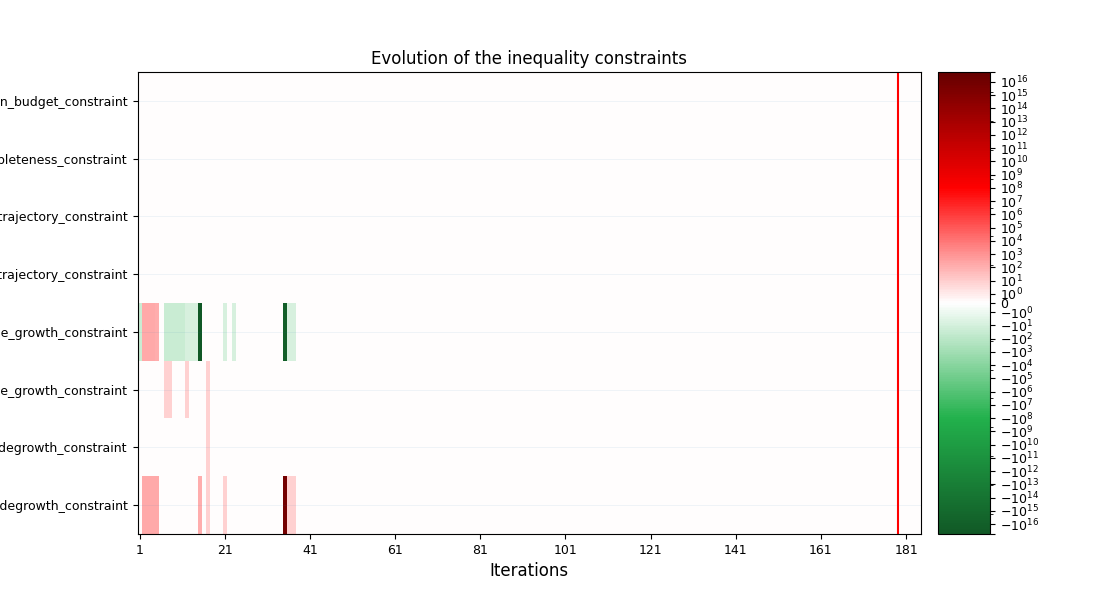

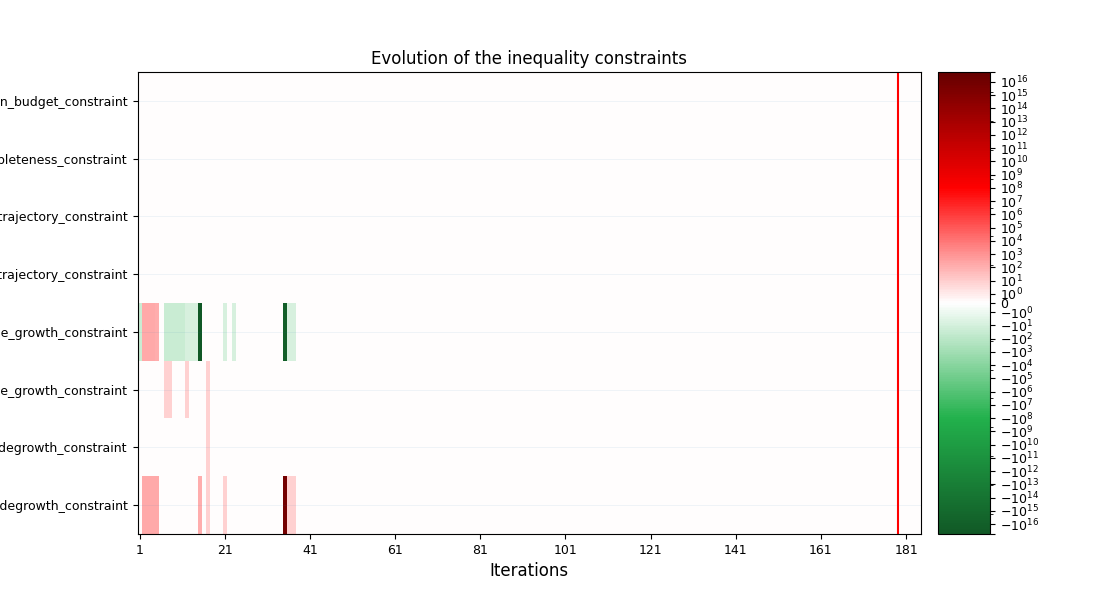

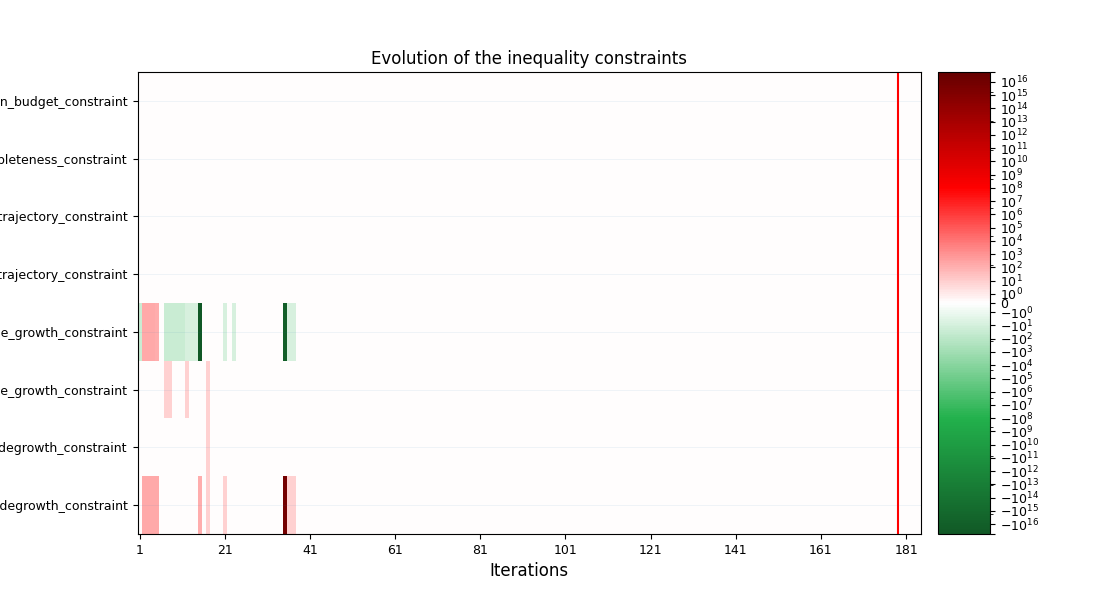

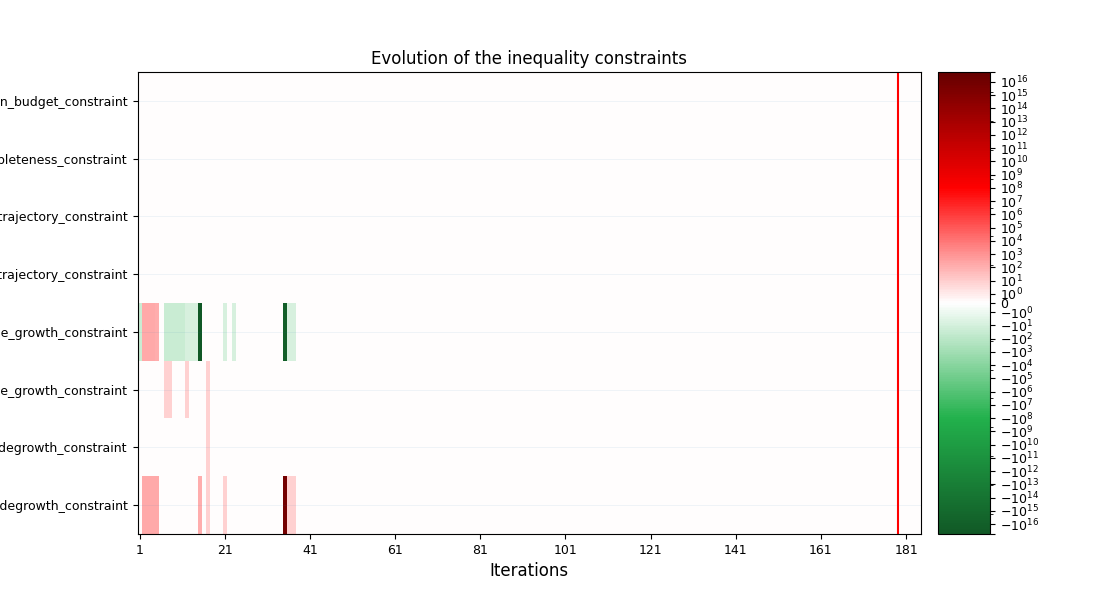

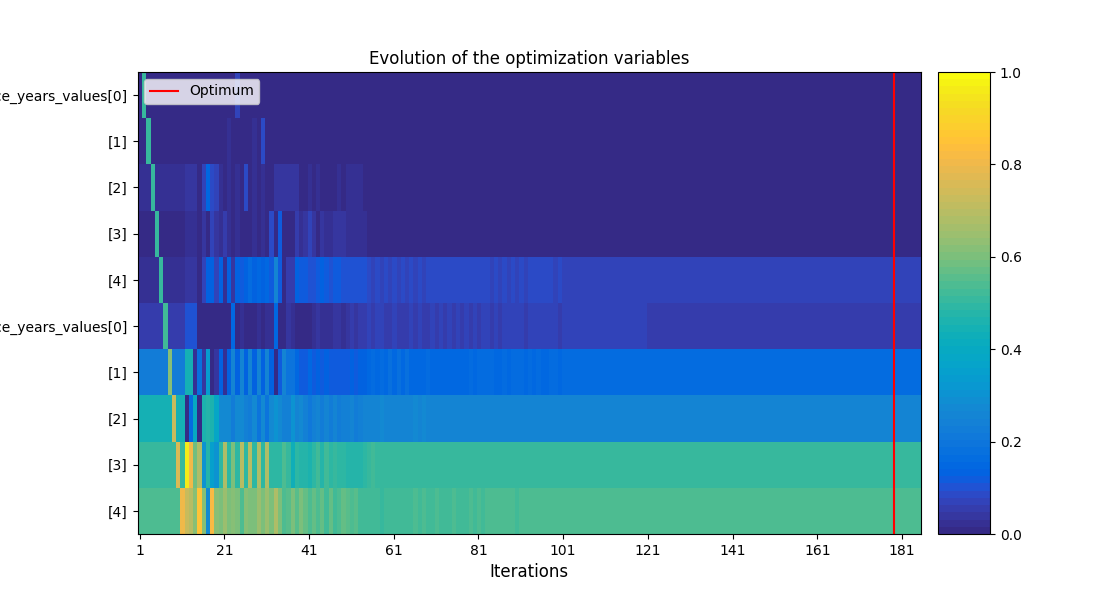

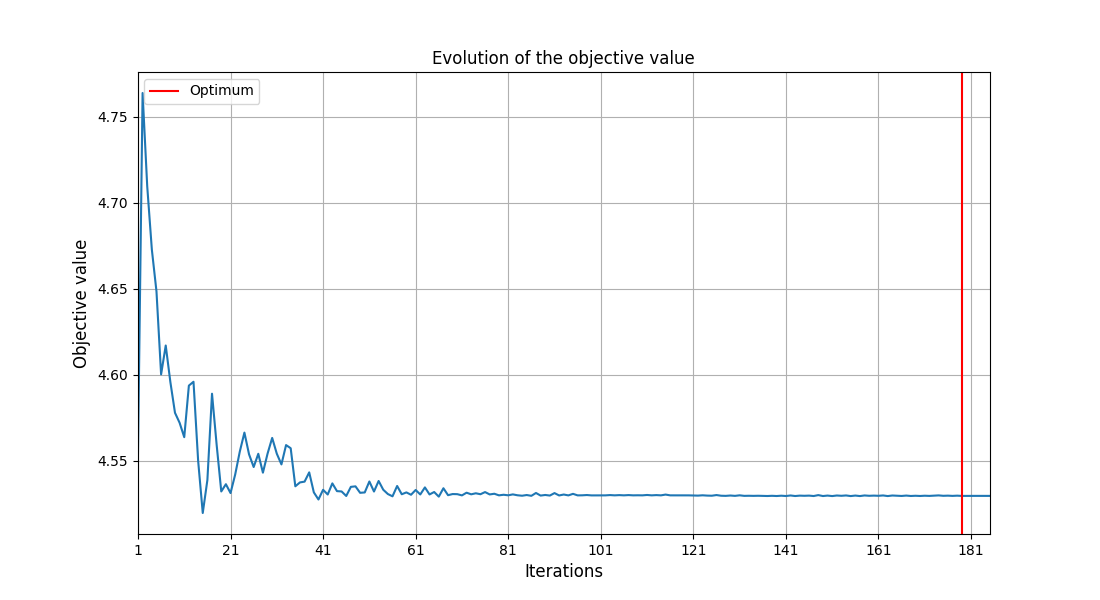

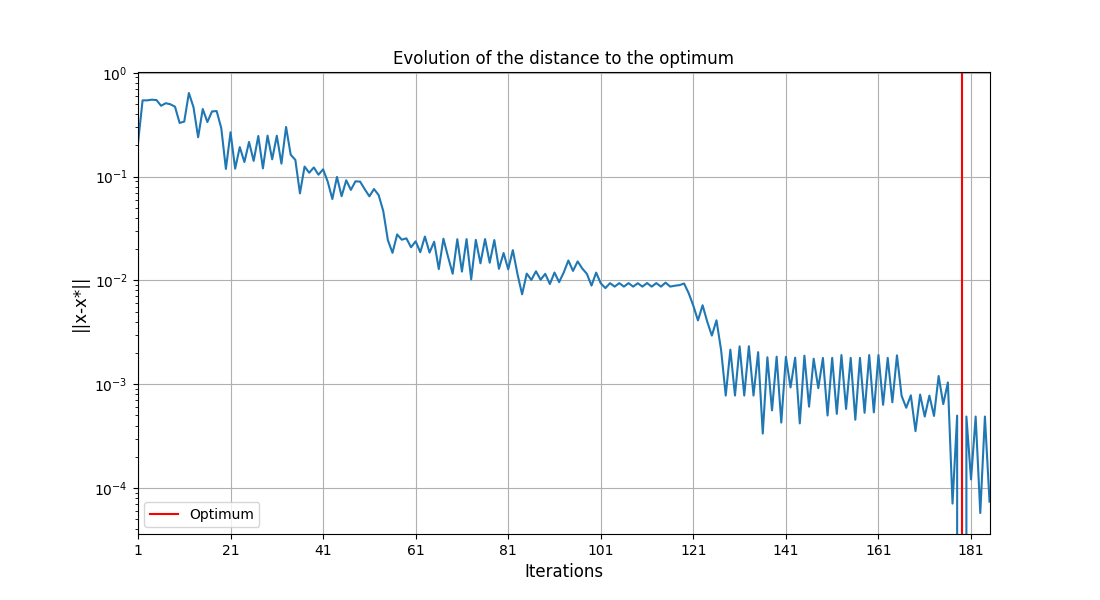

In [21]:
process.scenario.post_process("OptHistoryView", save=False, show=True)

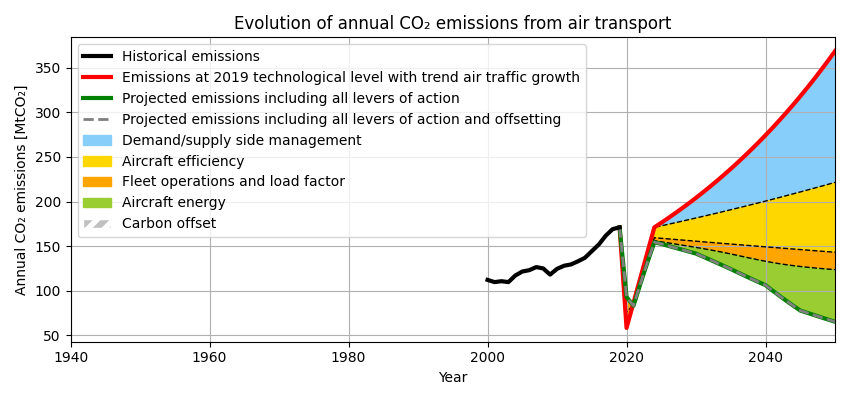

In [22]:
process.plot("air_transport_co2_emissions")

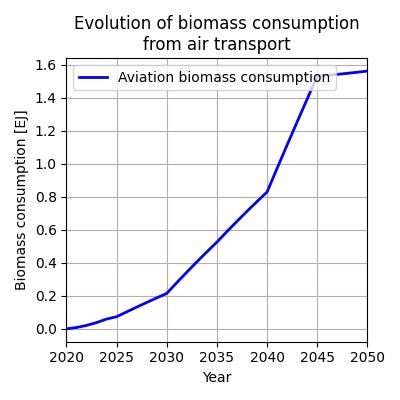

In [23]:
process.plot("biomass_consumption")

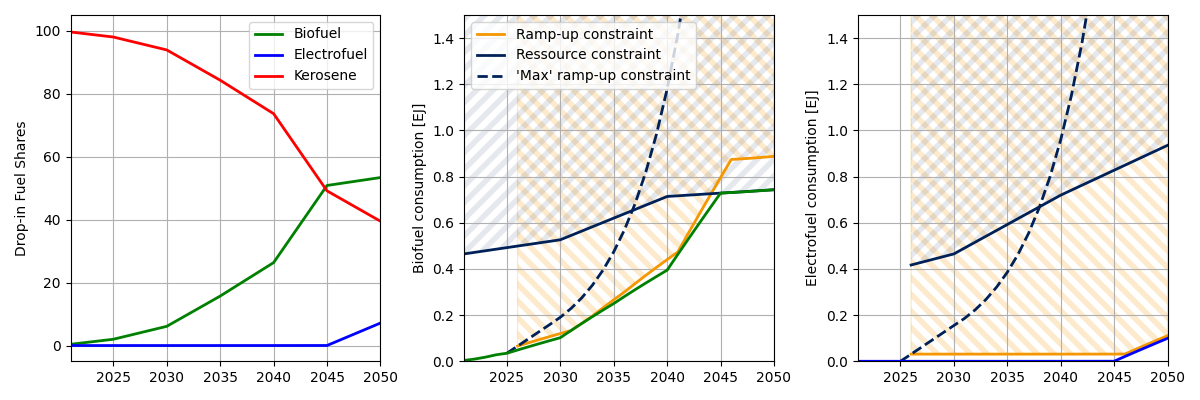

In [24]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,4))

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_share"],
    color="green",
    linestyle="-",
    label="Biofuel",
    linewidth=2,
)

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_share"],
    color="blue",
    linestyle="-",
    label="Electrofuel",
    linewidth=2,
)

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "kerosene_share"],
    color="red",
    linestyle="-",
    label="Kerosene",
    linewidth=2,
)

ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021,2050)




ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_biofuel_growth_constraint_viz"]/1e12,
    color="#F59700",
    linestyle="-",
    label="Ramp-up constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_biofuel_growth_constraint_viz"]/1e12,
    3,   
    hatch='\\\\',  
    edgecolor="#F59700",
    facecolor='none',
    alpha=0.2
)



ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_max_availability_viz"]/1e12,
    color="#002157",
    linestyle="-",
    label="Ressource constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_max_availability_viz"]/1e12,
    3,   
    hatch='//',  
    edgecolor="#002157",
    facecolor='none',
    linewidth=0,
    alpha=0.1
)


ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_growth_constraint_theoretical_max_viz"]/1e12,
    color="#002157",
    linestyle="--",
    label="'Max' ramp-up constraint",
    linewidth=2,
)


ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "energy_consumption_biofuel"]/1e12,
    color="green",
    linestyle="-",
    # label="Aviation biofuel consumption",
    linewidth=2,
)



ax2.grid()
# ax2.set_xlabel("Year")
ax2.set_ylabel("Biofuel consumption [EJ]")
ax2.legend(loc='upper left')
ax2.set_xlim(2021,2050)
ax2.set_ylim(0,1.5)



ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_electrofuel_growth_constraint_viz"]/1e12,
    color="#F59700",
    linestyle="-",
    # label="Electrofuel ramp-up constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_electrofuel_growth_constraint_viz"]/1e12,
    3,   
    hatch='\\\\',  
    edgecolor="#F59700",
    facecolor='none',
    alpha=0.2
)



ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_max_availability_viz"]/1e12,
    color="#002157",
    linestyle="-",
    # label="Electricity availability constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_max_availability_viz"]/1e12,
    3,   
    hatch='//',  
    edgecolor="#002157",
    facecolor='none',
    linewidth=0,
    alpha=0.1
)


ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_growth_constraint_theoretical_max_viz"]/1e12,
    color="#002157",
    linestyle="--",
    # label="Electrofuel theoretical max ramp-Up constraint",
    linewidth=2,
)


ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "energy_consumption_electrofuel"]/1e12,
    color="blue",
    linestyle="-",
    # label="Aviation electrofuel consumption",
    linewidth=2,
)


ax3.grid()
ax3.set_ylabel("Electrofuel consumption [EJ]")
ax3.set_xlim(2021,2050)
ax3.set_ylim(0,1.5)

fig.tight_layout()
fig.savefig('ressource_constraints.png', dpi=800)


In [31]:
process.vector_outputs_df["cumulative_co2_emissions"][2050]

3.4662277809731905

In [32]:
process.vector_outputs_df["co2_emissions_including_energy"][2050]


65.02530323774688

In [33]:
process.vector_outputs_df["cumulative_total_airline_cost_discounted"][2050]

4529551207184.197

In [34]:
max(process.vector_outputs_df["electricity_consumption"].dropna())

0.22781276958279642

In [35]:
sum(process.vector_outputs_df["electricity_consumption"].dropna())

0.691487504489548

In [36]:
max(process.vector_outputs_df["biomass_consumption"].dropna())

1.5612273037408353

In [37]:
sum(process.vector_outputs_df["biomass_consumption"].dropna())

20.572699528844915